In [1]:
# !pip install matplotlib openpyxl accelerate

import os
import torch
import pyarrow
import re

import numpy as np
import pandas as pd
import datasets
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from compare_models_tobasum import Bleurt, Mpnet, ModernBERT

torch.set_float32_matmul_precision('high')
os.environ["TOKENIZERS_PARALLELISM"] = "true"

/home/jovyan/conda_envs/metrics_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipes = {
    "Mpnet_pipe":    Mpnet(),
    "Bleurt_pipe":   Bleurt(),
    "ModernBERT_pipe": ModernBERT()
}

Device set to use cuda
Device set to use cuda
Device set to use cuda


In [3]:
dataset_path = "../bin/multirc_dataset.hf"

ds = datasets.DatasetDict.load_from_disk(dataset_path)

In [4]:
# Test reference answer normalization
for sample in ds["test"]:
    try:
        response, reference = sample["text"].split("</s>")
        reference = reference.strip().removeprefix("Answer:").strip()
    except:
        print(sample["text"])

In [ ]:
# def evaluate_all_models(dataset, pipes, label_key="labels"):
#     texts       = []
#     true_labels = []
#     preds_dict  = {name: [] for name in pipes}

#     for example in dataset["test"]:
        
#         text       = example["text"]
#         reference  = example.get("reference", None)  
#         label      = example[label_key]

        
#         texts.append(text)
#         true_labels.append(label)

        
#         for name, pipe in pipes.items():
#             pred_label = pipe(text, reference)
#             preds_dict[name].append(pred_label)

    
#     results_dict = {
#         "input_text": texts,
#         "true_label": true_labels,
#     }
#     for name, preds in preds_dict.items():
#         results_dict[f"{name}_pred"] = preds

    
#     return pd.DataFrame(results_dict)


# df_predictions = evaluate_all_models(ds, pipes)
# print(df_predictions.head())


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (214 > 128). Running this sequence through the model will result in indexing errors


In [5]:
def evaluate_and_score(dataset, pipes, label_key="labels"):
  
    texts, true_labels = [], []
    all_preds = { name: [] for name in pipes }

    for ex in dataset["test"]:
        text  = ex["text"]
        label = ex[label_key]

        texts.append(text)
        true_labels.append(label)

        for name, pipe in pipes.items():
            # call each adapter exactly once
            pred = pipe(text, ex.get("reference", None))  
            all_preds[name].append(pred)

    df = pd.DataFrame({
        "input_text":  texts,
        "true_label":  true_labels,
        **{ f"{n}_pred": preds for n, preds in all_preds.items() }
    })

    def score(col):
        return {
            "accuracy": accuracy_score(df["true_label"], df[col]),
            "f1_macro":  f1_score(df["true_label"], df[col], average="macro")
        }

    metrics = {
        name: score(f"{name}_pred")
        for name in pipes
    }

    return df, metrics

df_predictions_multirc, results = evaluate_and_score(ds, pipes)

# df_predictions_multirc.to_csv("predicted_labels_all_models.csv", index=False)
print(df_predictions_multirc.head(), "\n")

for model_name, m in results.items():
    print(f"{model_name}:  acc={m['accuracy']:.4f}, f1_macro={m['f1_macro']:.4f}")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (214 > 128). Running this sequence through the model will result in indexing errors


                                          input_text  true_label  \
0  The Women's Haven of Tarrant County</s>\nAnswe...           1   
1  Tarrant county shelters</s>\nAnswer: The Women...           0   
2  Female's Safe House of Haven County</s>\nAnswe...           0   
3                      California</s>\nAnswer: Texas           0   
4                           Texas</s>\nAnswer: Texas           1   

   Mpnet_pipe_pred  Bleurt_pipe_pred  ModernBERT_pipe_pred  
0                1                 1                     1  
1                0                 0                     0  
2                0                 1                     1  
3                0                 0                     0  
4                1                 1                     1   

Mpnet_pipe:  acc=0.8107, f1_macro=0.8050
Bleurt_pipe:  acc=0.6287, f1_macro=0.5360
ModernBERT_pipe:  acc=0.7961, f1_macro=0.7929


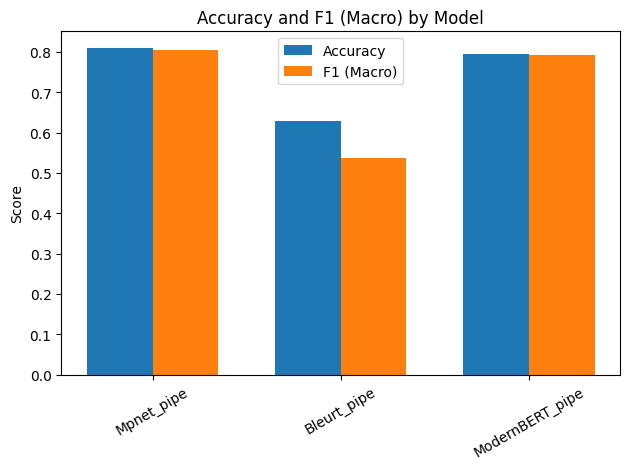

In [6]:
models = list(results.keys())
accuracies = [results[m]["accuracy"] for m in models]
f1s        = [results[m]["f1_macro"] for m in models]

x = range(len(models))
width = 0.35

plt.figure()
plt.bar([xi - width/2 for xi in x], accuracies, width)
plt.bar([xi + width/2 for xi in x], f1s, width)
plt.xticks(x, models, rotation=30)
plt.ylabel("Score")
plt.title("Accuracy and F1 (Macro) by Model")
plt.legend(["Accuracy", "F1 (Macro)"])
plt.tight_layout()
plt.show()


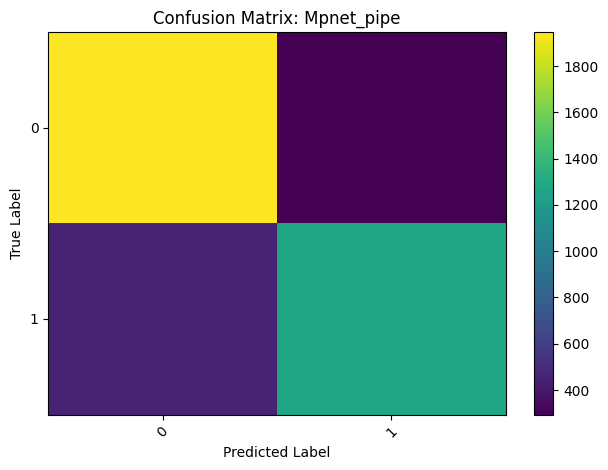

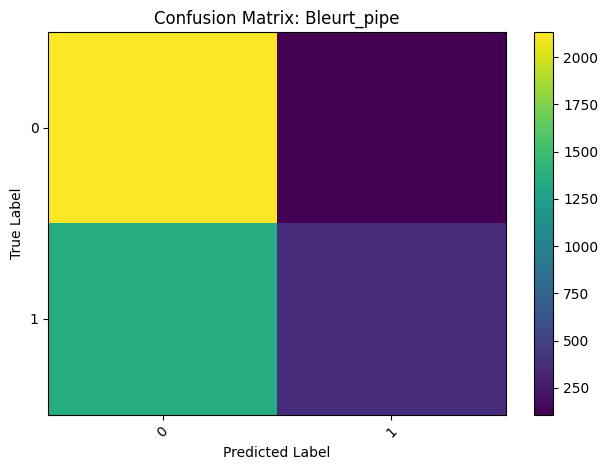

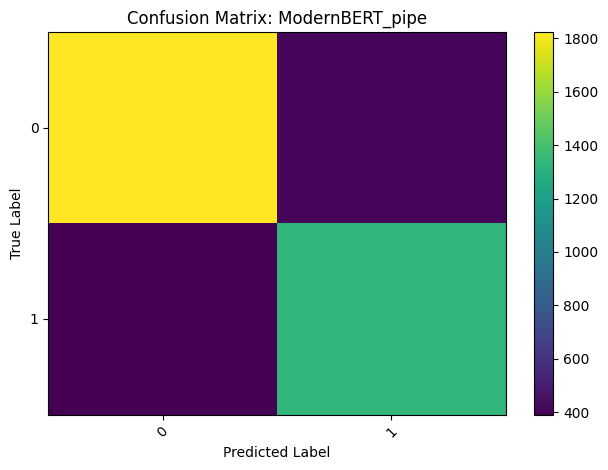

In [7]:
labels = sorted(df_predictions_multirc["true_label"].unique())

for name in models:
    cm = confusion_matrix(
        df_predictions_multirc["true_label"],
        df_predictions_multirc[f"{name}_pred"],
        labels=labels
    )
    plt.figure()
    plt.imshow(cm, aspect='auto')
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {name}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [8]:
def generate_classification_reports(df, models):
    
    reports = {}

    for model in models:
        preds = df[f"{model}_pred"]
        true_labels = df["true_label"]

        report = classification_report(true_labels, preds, output_dict=True)
        reports[model] = report

        print(f"\nClassification Report for {model}:\n")
        print(classification_report(true_labels, preds))

    return reports

classification_reports = generate_classification_reports(df_predictions_multirc, models)



Classification Report for Mpnet_pipe:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2240
           1       0.81      0.74      0.77      1722

    accuracy                           0.81      3962
   macro avg       0.81      0.80      0.80      3962
weighted avg       0.81      0.81      0.81      3962


Classification Report for Bleurt_pipe:

              precision    recall  f1-score   support

           0       0.61      0.95      0.74      2240
           1       0.77      0.21      0.33      1722

    accuracy                           0.63      3962
   macro avg       0.69      0.58      0.54      3962
weighted avg       0.68      0.63      0.56      3962


Classification Report for ModernBERT_pipe:

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2240
           1       0.76      0.77      0.77      1722

    accuracy                           0.80      3962
  

In [3]:
sheet_id   = "1qZc2b8wWlIRhxDr6Z9r6tzOcLsBrLXmKBvj4zp7-qHU"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx"
all_sheets = pd.read_excel(export_url, sheet_name=None)

filtered = {
    name: df
    for name, df in all_sheets.items()
    if not re.fullmatch(r"\d+", name)
       and name != "Instructions"
}

dfs = []
for sheet_name, df in filtered.items():
    tmp = df.copy()
    tmp["sheet_name"] = sheet_name
    dfs.append(tmp)
combined = pd.concat(dfs, ignore_index=True)

print(f"📊 Combined DataFrame shape: {combined.shape}")
print("→ Columns before renaming:", combined.columns.tolist())
print("→ A few rows before renaming:")
print(combined.head(2), "\n")

combined = combined.rename(columns={
    "chunk_text":       "text",
    "reference_answer": "reference",
    "score (1-4)":      "labels"
})
print("→ Columns after renaming:", combined.columns.tolist())

combined["labels"] = (combined["labels"] >= 3).astype(int)

print("\n🔍 Checking the 'text' column:")
print("  • dtype:", combined["text"].dtype)
print("  • num nulls:", combined["text"].isnull().sum())
print("  • example values:")
print(combined["text"].dropna().head(3).tolist())

print("\n🔍 Checking the 'reference' column:")
print("  • dtype:", combined["reference"].dtype)
print("  • num nulls:", combined["reference"].isnull().sum())
print("  • example values:")
print(combined["reference"].dropna().head(3).tolist())

print("\n🔍 Checking the 'labels' column (after binarization):")
print("  • dtype:", combined["labels"].dtype)
print("  • unique values:", combined["labels"].unique())
print("  • value counts:\n", combined["labels"].value_counts(), "\n")

sheet_human_scored = {
    "test": combined.to_dict(orient="records")
}

print(f"✅ sheet_human_scored.keys(): {list(sheet_human_scored.keys())}")
print(f"→ Number of examples in sheet_human_scored['test']: {len(sheet_human_scored['test'])}")
print("→ Example record[0]:", sheet_human_scored["test"][0])


📊 Combined DataFrame shape: (390, 9)
→ Columns before renaming: ['annotator_id', 'question_id', 'chunk_header', 'chunk_text', 'question', 'reference_answer', 'response', 'score (1-4)', 'sheet_name']
→ A few rows before renaming:
   annotator_id                           question_id  \
0             0  38f590ee-1964-4a7c-9625-53b53cb8a9f0   
1             0  95784937-f565-4450-bfad-babc2399d667   

                                      chunk_header  \
0  0.1 Affect Detection from Student Activity Data   
1  0.1 Affect Detection from Student Activity Data   

                                          chunk_text  \
0  Affective states cannot be directly measured b...   
1  Affective states cannot be directly measured b...   

                                            question  \
0  What approach was used to infer affect by anal...   
1  What approach was used to infer affect by anal...   

                                    reference_answer  response  score (1-4)  \
0  The interaction-

In [9]:
# HUMAN-SCORED METRICS

sheet_id   = "1qZc2b8wWlIRhxDr6Z9r6tzOcLsBrLXmKBvj4zp7-qHU"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx"

all_sheets = pd.read_excel(export_url, sheet_name=None)

filtered = {
    name: df for name, df in all_sheets.items()
    if not re.fullmatch(r"\d+", name)
}

dfs = []
for name, df in filtered.items():
    d = df.copy()
    d["sheet_name"] = name
    dfs.append(d)
combined = pd.concat(dfs, ignore_index=True)

# rename and binarize
combined = combined.rename(
    columns={"reference_answer": "reference", "chunk_text": "text", "score (1-4)": "labels"}
)
combined["labels"] = (combined["labels"] >= 3).astype(int)

sheet_human_scored = {
    "test": combined.to_dict(orient="records")
}

# check label space
print("\nUnique labels after binarization:", combined["labels"].unique())



Unique labels after binarization: [0 1]


In [10]:
human_scored_preds, sheet_metrics = evaluate_and_score(sheet_human_scored, pipes)

print(human_scored_preds.head(), "\n")

for model_name, m in sheet_metrics.items():
    print(f"{model_name}:  acc={m['accuracy']:.4f}, f1_macro={m['f1_macro']:.4f}")

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLargeIndex: block: [163,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLargeIndex: block: [163,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLargeIndex: block: [163,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLargeIndex: block: [163,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLargeIndex: block: [163,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/nativ

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
models = list(sheet_metrics.keys())
accuracies = [sheet_metrics[m]["accuracy"] for m in models]
f1s        = [sheet_metrics[m]["f1_macro"] for m in models]

x = range(len(models))
width = 0.35

plt.figure()
plt.bar([xi - width/2 for xi in x], accuracies, width)
plt.bar([xi + width/2 for xi in x], f1s, width)
plt.xticks(x, models, rotation=30)
plt.ylabel("Score")
plt.title("Accuracy and F1 (Macro) by Model")
plt.legend(["Accuracy", "F1 (Macro)"])
plt.tight_layout()
plt.show()

In [ ]:
labels = sorted(human_scored_preds["true_label"].unique())

for name in models:
    cm = confusion_matrix(
        df_predictions_multirc["true_label"],
        df_predictions_multirc[f"{name}_pred"],
        labels=labels
    )
    plt.figure()
    plt.imshow(cm, aspect='auto')
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {name}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [ ]:
classification_reports_humanscored = generate_classification_reports(human_scored_preds, models)